In [ ]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


# Pytorch device specific configuration
# # Pytorch Gpu Configuration for cuda
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Pytorch Gpu Configuration for dml devices
import torch_directml

device = torch_directml.device()

# Set default devices
torch.set_default_device(device)

In [2]:
# Generate data
def generate_data(n, batchSize=16):
    data = torch.randint(low=-10000, high=10000, size=(n, 2)).float()
    labels = torch.sum(data, axis=1, keepdim=True)

    # train test splits
    train_data, test_data_temp, train_labels, test_labels_temp = train_test_split(
        data, labels, train_size=0.8
    )
    test_data, dev_data, test_labels, dev_labels = train_test_split(
        test_data_temp, test_labels_temp, train_size=0.5
    )

    # Pytorch datasets
    train_dataT = TensorDataset(train_data, train_labels)
    dev_dataT = TensorDataset(dev_data, dev_labels)
    test_dataT = TensorDataset(test_data, test_labels)

    # Dataloader objects
    train_loader = DataLoader(
        train_dataT,
        batch_size=batchSize,
        shuffle=True,
        drop_last=True,
        generator=torch.Generator(device),
    )
    dev_loader = DataLoader(
        dev_dataT,
        batch_size=dev_dataT.tensors[0].shape[0],
        generator=torch.Generator(device),
    )
    test_loader = DataLoader(
        test_dataT,
        batch_size=test_dataT.tensors[0].shape[0],
        generator=torch.Generator(device),
    )
    return train_loader, dev_loader, test_loader

In [3]:
def createTheModel():
    class Sum2NumbersClass(nn.Module):
        def __init__(self):
            super().__init__()

            # Input
            self.input = nn.Linear(2, 64)
            # Hidden Layers
            self.hidden1 = nn.Linear(64, 64)
            self.hidden2 = nn.Linear(64, 64)
            # Output Layers
            self.output = nn.Linear(64, 1)

        def forward(self, x):
            # Input
            x = F.relu(self.input(x))

            # Hidden Layers
            x = F.relu(self.hidden1(x))
            x = F.relu(self.hidden2(x))

            # Output Layers
            return self.output(x)

    net = Sum2NumbersClass()

    # Loss Function
    lossFun = nn.MSELoss()

    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.005)

    return net, lossFun, optimizer

In [4]:
# Test the model
net, lossFun, optimizer = createTheModel()
tempData = torch.tensor(100 * np.random.randn(100, 2)).float()
print(net(tempData))

tensor([[ 1.7814],
        [ 1.6535],
        [ 4.1430],
        [ 7.9340],
        [ 3.0741],
        [ 2.1728],
        [ 0.7957],
        [ 7.3026],
        [ 3.0223],
        [ 1.1564],
        [ 6.9203],
        [ 2.3732],
        [ 4.7910],
        [ 3.3954],
        [ 3.7788],
        [ 3.2128],
        [ 3.0102],
        [13.7771],
        [ 5.9975],
        [ 3.8686],
        [ 4.3898],
        [ 0.4956],
        [14.0137],
        [ 6.1335],
        [ 8.4413],
        [ 7.8194],
        [ 2.3675],
        [ 6.2693],
        [ 3.2089],
        [ 1.9165],
        [ 4.6374],
        [ 1.8621],
        [18.9313],
        [ 6.3767],
        [ 8.4417],
        [ 4.1312],
        [ 3.6463],
        [ 5.6098],
        [ 5.2215],
        [ 2.1086],
        [ 6.5628],
        [ 2.4044],
        [ 8.6990],
        [ 3.3449],
        [ 0.8201],
        [ 9.4830],
        [ 3.0339],
        [ 5.6820],
        [ 0.3543],
        [ 5.4277],
        [ 7.0859],
        [ 3.6867],
        [ 7.

In [5]:
nEpochs = 10


def trainTheModel():
    # Initialize variables
    trainAcc = np.zeros(nEpochs)
    devAcc = []
    losses = np.zeros(nEpochs)

    # The loop
    for epoch in range(nEpochs):
        # Model training mode
        net.train()

        # Batch loss and accuracy initialization
        batchLoss = []
        batchAcc = []

        # The batch loop
        for X, y in train_loader:

            # Forward pass
            yHat = net(X)
            loss = lossFun(yHat, y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Batch Loss and accuracy
            batchLoss.append(loss.cpu().item())
            batchAcc.append((100 * torch.mean((torch.abs(yHat - y) < 1).float())).cpu())

        # Batch loop end

        # Train Acc
        trainAcc[epoch] = np.mean(batchAcc)
        losses[epoch] = np.mean(batchLoss)

        # Dev accuracy
        net.eval()
        # create brand new test data
        X, y = next(iter(dev_loader))
        with torch.no_grad():
            yHat = net(X)
        devAcc.append((100 * torch.mean((torch.abs(yHat - y) < 1).float())).cpu())
    # The Loop End

    return trainAcc, devAcc, losses

In [6]:
# Model Experiment
n = 10000
for i in range(1):
    print(f"######## Experiment: {i+1} ########")
    # Generate the data
    train_loader, dev_loader, test_loader = generate_data(n)

    # Model Instance
    net, lossFun, optimizer = createTheModel()
    # Train the model
    trainAcc, devAcc, losses = trainTheModel()
    # report accuracy
    print(
        "Model instance %s, final TRAIN/DEV accuracies: %g%%, %g%%"
        % (i + 1, np.max(trainAcc), np.max(devAcc))
    )

######## Experiment: 1 ########


/home/kumar/anaconda3/envs/dml/lib/python3.10/site-packages/torch/utils/_device.py:78: UserWarning: The operator 'aten::_foreach_add_.Scalar' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /__w/1/s/pytorch-directml-plugin/torch_directml/csrc/dml/dml_cpu_fallback.cpp:15.)
  return func(*args, **kwargs)


Model instance 1, final TRAIN/DEV accuracies: 6.3625%, 13.7%


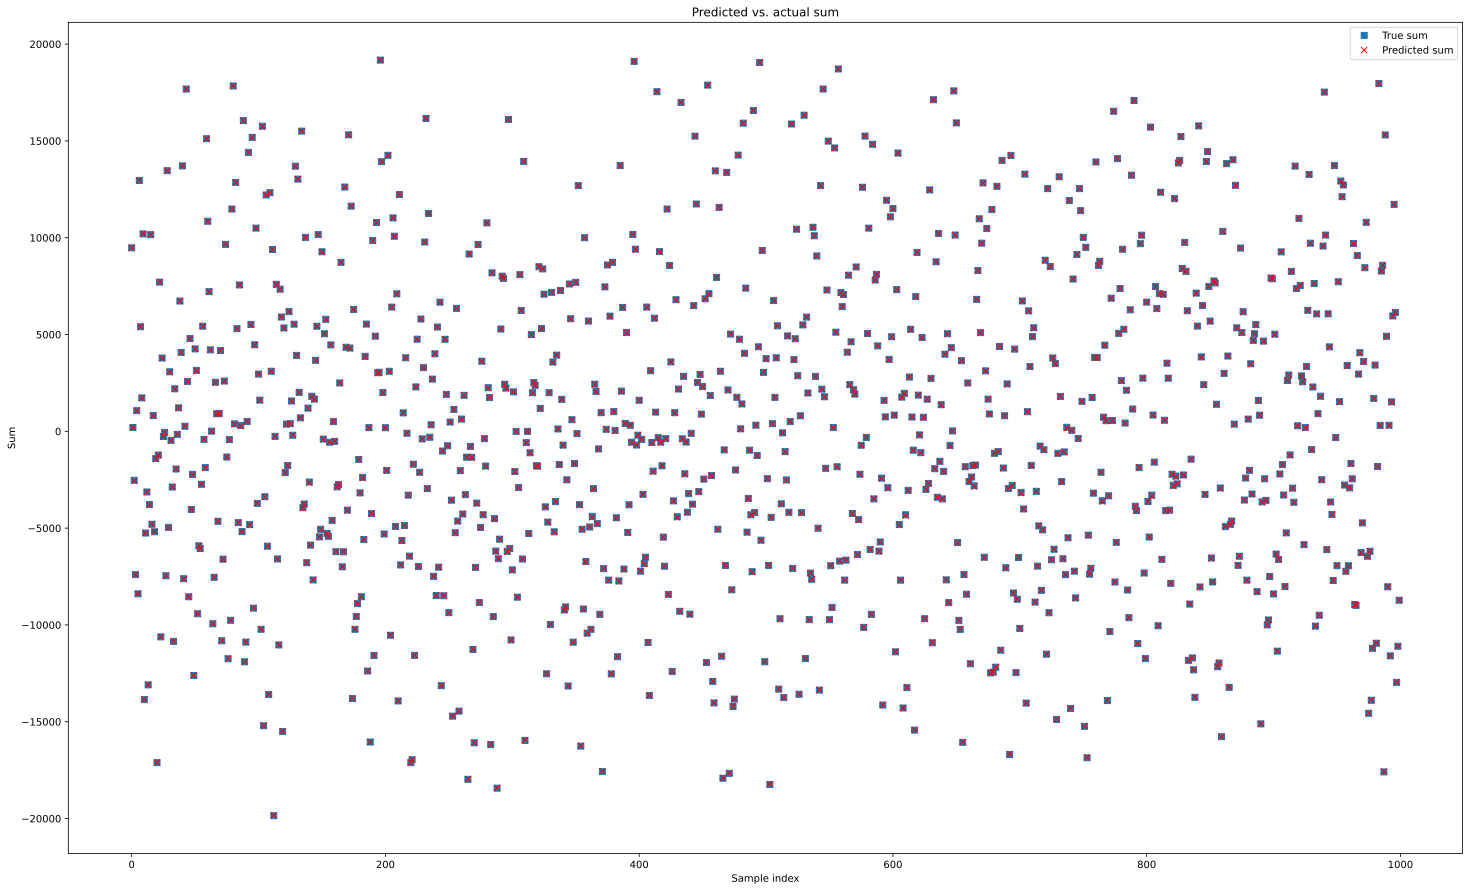

In [7]:
# some plots from the final model
X, y = next(iter(test_loader))

# evaluate the model and compute accuracy
with torch.no_grad():
    yHat = net(X)

fig = plt.figure(figsize=(25, 15))
plt.plot(y.cpu(), "s")
plt.plot(yHat.cpu(), "rx")
plt.legend(["True sum", "Predicted sum"])
plt.xlabel("Sample index")
plt.ylabel("Sum")
plt.title(f"Predicted vs. actual sum")
plt.show()

In [ ]:
print(f"Test Accuracy: {torch.mean((torch.abs(yHat - y) < 35).float()) * 100}")

Test Accuracy: 99.00000762939453
